In [1]:
# Movie Reviews

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [3]:
# Function for feature building and extraction on natural language data

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, stop_words={'crazy'}, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
#     X_quant_features = movie_data[["word_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [5]:
# Create Training Data

In [6]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./data/moviereviews_train.tsv', my_random_seed=13)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


In [7]:
# Fit Various models
# Ordinary least squares model

In [8]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 5170, 'TN': 4714, 'FP': 5284, 'FN': 4832, 'Accuracy': 0.4942, 'Precision': 0.49454754161086667, 'Recall': 0.5168966206758648, 'desc': 'ols_train'}


In [9]:
# Model SVM, linear

In [10]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


In [34]:
# SVC
from sklearn import svm
# Default
svm_svc = svm.LinearSVC()
svm_svc.fit(X_train, y_train)

svm_svc_performance_train = BinaryClassificationPerformance(svm_svc.predict(X_train), y_train, 'svm_svc_train')
svm_svc_performance_train.compute_measures()
print(svm_svc_performance_train.performance_measures)

# c=100
svm_svc_100 = svm.LinearSVC(C=100)
svm_svc_100.fit(X_train, y_train)

svm_svc_performance_train_100 = BinaryClassificationPerformance(svm_svc_100.predict(X_train), y_train, 'svm_svc_train_100')
svm_svc_performance_train_100.compute_measures()
print(svm_svc_performance_train_100.performance_measures)

# c=.1
svm_svc_1 = svm.LinearSVC(C=.1)
svm_svc_1.fit(X_train, y_train)

svm_svc_performance_train_1 = BinaryClassificationPerformance(svm_svc_1.predict(X_train), y_train, 'svm_svc_train_1')
svm_svc_performance_train_1.compute_measures()
print(svm_svc_performance_train_1.performance_measures)

# c=.0001
svm_svc_0001 = svm.LinearSVC(C=.0001)
svm_svc_0001.fit(X_train, y_train)

svm_svc_performance_train_0001 = BinaryClassificationPerformance(svm_svc_0001.predict(X_train), y_train, 'svm_svc_train_0001')
svm_svc_performance_train_0001.compute_measures()
print(svm_svc_performance_train_0001.performance_measures)

# c=.000001
svm_svc_000001 = svm.LinearSVC(C=.000001)
svm_svc_000001.fit(X_train, y_train)

svm_svc_performance_train_000001 = BinaryClassificationPerformance(svm_svc_000001.predict(X_train), y_train, 'svm_svc_train_000001')
svm_svc_performance_train_000001.compute_measures()
print(svm_svc_performance_train_000001.performance_measures)

# c=.00000001
svm_svc_00000001 = svm.LinearSVC(C=.00000001)
svm_svc_00000001.fit(X_train, y_train)

svm_svc_performance_train_00000001 = BinaryClassificationPerformance(svm_svc_00000001.predict(X_train), y_train, 'svm_svc_train_00000001')
svm_svc_performance_train_00000001.compute_measures()
print(svm_svc_performance_train_00000001.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_svc_train'}
{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_svc_train_100'}
{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_svc_train_1'}
{'Pos': 10002, 'Neg': 9998, 'TP': 10001, 'TN': 9998, 'FP': 0, 'FN': 1, 'Accuracy': 0.99995, 'Precision': 1.0, 'Recall': 0.9999000199960008, 'desc': 'svm_svc_train_0001'}
{'Pos': 10002, 'Neg': 9998, 'TP': 9522, 'TN': 9759, 'FP': 239, 'FN': 480, 'Accuracy': 0.96405, 'Precision': 0.9755148038110849, 'Recall': 0.9520095980803839, 'desc': 'svm_svc_train_000001'}
{'Pos': 10002, 'Neg': 9998, 'TP': 8728, 'TN': 9759, 'FP': 239, 'FN': 1274, 'Accuracy': 0.92435, 'Precision': 0.9733467157354745, 'Recall': 0.872625474905019, 'desc': 'svm_svc_train_00000001'}


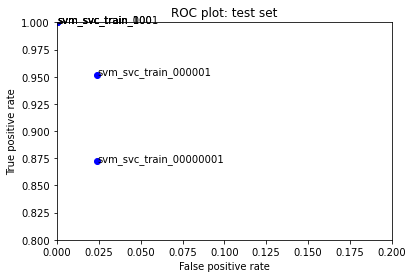

In [38]:
fits = [svm_svc_performance_train, svm_svc_performance_train_100, svm_svc_performance_train_1, svm_svc_performance_train_0001, svm_svc_performance_train_000001, svm_svc_performance_train_00000001]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, .2, .8, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [39]:
# default
svm_svc_performance_test = BinaryClassificationPerformance(svm_svc.predict(X_test), y_test, 'svm_svc_test')
svm_svc_performance_test.compute_measures()
print(svm_svc_performance_test.performance_measures)

# 100
svm_svc_performance_test_100 = BinaryClassificationPerformance(svm_svc_100.predict(X_test), y_test, 'svm_svc_test_100')
svm_svc_performance_test_100.compute_measures()
print(svm_svc_performance_test_100.performance_measures)

# .1
svm_svc_performance_test_1 = BinaryClassificationPerformance(svm_svc_1.predict(X_test), y_test, 'svm_svc_test_1')
svm_svc_performance_test_1.compute_measures()
print(svm_svc_performance_test_1.performance_measures)

# .0001
svm_svc_performance_test_0001 = BinaryClassificationPerformance(svm_svc_0001.predict(X_test), y_test, 'svm_svc_test_0001')
svm_svc_performance_test_0001.compute_measures()
print(svm_svc_performance_test_0001.performance_measures)

# .000001
svm_svc_performance_test_000001 = BinaryClassificationPerformance(svm_svc_000001.predict(X_test), y_test, 'svm_svc_test_000001')
svm_svc_performance_test_000001.compute_measures()
print(svm_svc_performance_test_000001.performance_measures)

# .00000001
svm_svc_performance_test_00000001 = BinaryClassificationPerformance(svm_svc_00000001.predict(X_test), y_test, 'svm_svc_test_00000001')
svm_svc_performance_test_00000001.compute_measures()
print(svm_svc_performance_test_00000001.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2162, 'TN': 2120, 'FP': 382, 'FN': 336, 'Accuracy': 0.8564, 'Precision': 0.8498427672955975, 'Recall': 0.8654923939151321, 'desc': 'svm_svc_test'}
{'Pos': 2498, 'Neg': 2502, 'TP': 2162, 'TN': 2120, 'FP': 382, 'FN': 336, 'Accuracy': 0.8564, 'Precision': 0.8498427672955975, 'Recall': 0.8654923939151321, 'desc': 'svm_svc_test_100'}
{'Pos': 2498, 'Neg': 2502, 'TP': 2162, 'TN': 2120, 'FP': 382, 'FN': 336, 'Accuracy': 0.8564, 'Precision': 0.8498427672955975, 'Recall': 0.8654923939151321, 'desc': 'svm_svc_test_1'}
{'Pos': 2498, 'Neg': 2502, 'TP': 2186, 'TN': 2163, 'FP': 339, 'FN': 312, 'Accuracy': 0.8698, 'Precision': 0.8657425742574257, 'Recall': 0.8751000800640513, 'desc': 'svm_svc_test_0001'}
{'Pos': 2498, 'Neg': 2502, 'TP': 2145, 'TN': 2223, 'FP': 279, 'FN': 353, 'Accuracy': 0.8736, 'Precision': 0.8849009900990099, 'Recall': 0.8586869495596477, 'desc': 'svm_svc_test_000001'}
{'Pos': 2498, 'Neg': 2502, 'TP': 1902, 'TN': 2313, 'FP': 189, 'FN': 596, 'Accuracy

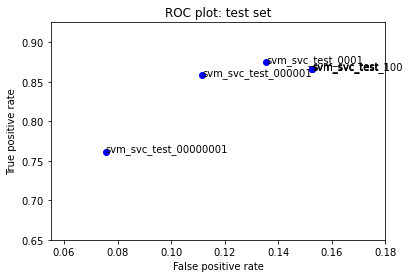

In [47]:
fits = [svm_svc_performance_test, svm_svc_performance_test_100, svm_svc_performance_test_1, svm_svc_performance_test_0001, svm_svc_performance_test_000001, svm_svc_performance_test_00000001]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0.055, .18, 0.65, .925])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [12]:
# Model Logistic regression

In [13]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


In [14]:
# Model Maive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 9586, 'TN': 9832, 'FP': 166, 'FN': 416, 'Accuracy': 0.9709, 'Precision': 0.9829778506972928, 'Recall': 0.9584083183363328, 'desc': 'nbs_train'}


In [16]:
# Model Perceptron

In [17]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


In [18]:
# Model Ridge Regression Classifier

In [104]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=500000)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 9591, 'TN': 9694, 'FP': 304, 'FN': 411, 'Accuracy': 0.96425, 'Precision': 0.969277412834765, 'Recall': 0.9589082183563288, 'desc': 'rdg_train'}


In [20]:
# model random forest classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 8298, 'TN': 7161, 'FP': 2837, 'FN': 1704, 'Accuracy': 0.77295, 'Precision': 0.7452177817691962, 'Recall': 0.829634073185363, 'desc': 'rdf_train'}


In [22]:
# ROC plor to compare performance of various models and fits

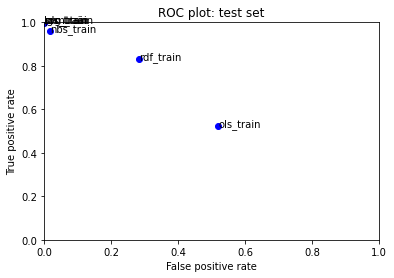

In [60]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

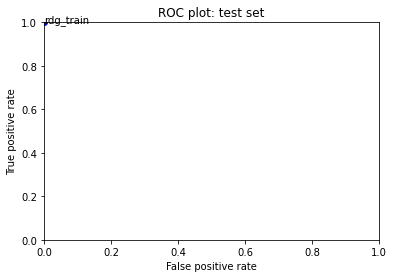

In [63]:
fits = [rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [24]:
# Looking at reviews based on their classification

In [25]:
ols_predictions = ols.predict(X_train)

In [26]:
# False positives

In [27]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')

Examples of false positives:
82
A man discovers that his parents were part of a nuclear experiment in the 50's and that he now has the power to... burst into flames! <br /><br />I was really geared up for this film, what with being directed by the great Toby Hooper and staring wild card Brad Dourif. Unfortunately it didn't rise above the average individual-with-violent-powers movie. Spontaneous Combustion has an interesting premise behind it, unfortunately it never seems to live up to its potential and prolongs its plot too much. The special effects aren't bad though and help to carry the movie to the finale.<br /><br />The cast isn't bad, Dourif does steal the show.<br /><br />All around, no classic but it's not the worst of its kind either.<br /><br />** out of ****
* * * * * * * * * 
193
Cecil B. deMille's 1922 parlor-to-prison tearjerker Manslaughter finds the lovely Leatrice Joy as a good-at-heart but decadent young lady with more money than she knows what to do with. Her reckless

3773
Five-year-old Michael sees his mother getting axed to death by his serial killer father \The Highwayman,\" who later commits suicide. \"20 years later\" grown Mike (Gordon Currie, from PUPPET MASTER 4 and 5) invites seven of his friends to his secluded grandparents home to \"master their own fears\" at a Halloween night costume party. Morty, a life-size wooden doll kept in the attic by the Indian handyman, becomes possessed by the dead father's spirit and kills them off using their phobias. Characters are thrown out a window, drowned in a toilet, eaten by rats, blown up, etc. Morty morphs into the dad and a tree, walks around and makes stupid wisecracks. After finding a girl chopped up and stuffed in a cardboard box, the characters remain in the house, act cheerful, crack jokes and have sex.<br /><br />The Morty design is good and Betsy Palmer (Mrs. Voorhees from the original Friday THE 13TH) is surprisingly delightful as the grandmother, but this thing is even more senseless and 

7209
I am giving this pretentious piece of garbage a 1 simply because i don't believe there is a worse movie in the world.<br /><br />I hate this movie, i hate the acting, dialog, setting, writing and directing. I hope everyone that was involved in this movie burns and rots in the darkest circle of hell.<br /><br />Damn this disgusting waste of time.<br /><br />I pray every day that this movie is just a figment of my imagination. i pray that i dreamt the movie, and that i will never have to see it at <br /><br />my local video store again.<br /><br />BURN IN HELL
* * * * * * * * * 
7234
When you go at an open air cinema under the Greek summer night you usually don't care what the movie is! Edison started really good with some good effort from the singers-who-want-to-be actors and a once again great Morgan Freeman but... (In a movie there is usually a good start to catch audience,done, a bit boring yet story filling middle of the movie that is more about characters and less about action

10756
This movie is one of the most awful I've ever seen. Not only is the dialogue awful, it never ends. You'll think it's ending, but it's not. How long is it, 140, 160 minutes? I don't even know. I do know that I'll never watch it again. It's like someone took a romantic comedy, took out the comedy, then decided to downplay the romance, leaving us with the pile of crap that managed to make its way to the screen. But don't take my word for it, find out for yourself how terrible this film is.
* * * * * * * * * 
10911
The first half of this movie is a pure delight. Novel. Funny. Wonderful performances. A close knit brother and sister living in Manhattan fall for the same woman! Adult. Bright. Witty. What more could you ask. As a romantic comedy this starts refreshing. It heads into unexplored territory. And then it falls apart.<br /><br />It goes from being a universal adult comedy to a coming-of-age coming-out-of-the-closet story that has been done many times before. What a disappointm

14170
Boy-girl love affair/sequel with songs, only this time she's the punkette and he's the straight arrow. Movie-buffs out there actually like this movie? It has fans? I must say, the mind reels... \Grease 2\" is a truly lame enterprise that doesn't even have the courage, moxy or sheer gall to take the memory of its predecessor down in flames (like \"Jaws 2\" or \"Exorcist II\"). No, it whimpers along in slow-motion and often just plays dead. It looks and feels cheap, with a large cast lost amidst messy direction and unfocused handling. This was the first time a substantial audience got a glimpse of Michelle Pfeiffer and, although she doesn't embarrass herself, it's a role worth forgetting. A misfire on the lowest of levels. NO STARS from ****"
* * * * * * * * * 
14193
Probably one of the most boriest slasher movies ever, badly acted and badly written.<br /><br />THE PLOT Five students staying behind during the holidays closing down a dorm, but somebody has designs on them and starts

17578
This is hands down the worst movie I can ever remember watching. Everything was unbelievably cliché and retarded. The acting was horrible too. The camera work wasn't bad but that still couldn't redeem it. The writer/director of this film must suffer from down's syndrome if he believed this movie would help his career. I want the hour and a half of my life back that I wasted watching this crap. I would rather watch a video of the grass growing than this. I cant believe IMDb is making me write 10 lines in order to post this but I feel that this movie is so bad that I must continue to warn others about it. The reason I came about this movie is that my girlfriend requested it from the local library thinking that it was the Kris Kristoferson movie which ended up being entitled \Disappearances\". I don't know whose fault it was for this garbage ending up in my DVD player but I feel that someone owes me at least $20 for my time, pain and suffering. In conclusion, the director/writer of 

In [28]:
# Look at performace on the test set
# Model ordinary least squares

In [29]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)


{'Pos': 2498, 'Neg': 2502, 'TP': 1335, 'TN': 1213, 'FP': 1289, 'FN': 1163, 'Accuracy': 0.5096, 'Precision': 0.508765243902439, 'Recall': 0.5344275420336269, 'desc': 'ols_test'}


In [30]:
# Model SVM linear

In [31]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2083, 'TN': 2072, 'FP': 430, 'FN': 415, 'Accuracy': 0.831, 'Precision': 0.8288897731794668, 'Recall': 0.8338670936749399, 'desc': 'svm_test'}


In [32]:
# Model logistic regression

In [33]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2090, 'TN': 2055, 'FP': 447, 'FN': 408, 'Accuracy': 0.829, 'Precision': 0.823807646826961, 'Recall': 0.8366693354683747, 'desc': 'lgs_test'}


In [34]:
# Model naive Bayes

In [35]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 1802, 'TN': 1880, 'FP': 622, 'FN': 696, 'Accuracy': 0.7364, 'Precision': 0.7433993399339934, 'Recall': 0.7213771016813451, 'desc': 'nbs_test'}


In [36]:
# Model precertron

In [37]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2078, 'TN': 2087, 'FP': 415, 'FN': 420, 'Accuracy': 0.833, 'Precision': 0.833533894905736, 'Recall': 0.8318654923939152, 'desc': 'prc_test'}


In [38]:
# Model Ridge regression classifier

In [105]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2192, 'TN': 2177, 'FP': 325, 'FN': 306, 'Accuracy': 0.8738, 'Precision': 0.8708780294000794, 'Recall': 0.877502001601281, 'desc': 'rdg_test'}


In [40]:
# Random Forest classifier

In [41]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2044, 'TN': 1783, 'FP': 719, 'FN': 454, 'Accuracy': 0.7654, 'Precision': 0.7397756062251176, 'Recall': 0.8182546036829463, 'desc': 'rdf_test'}


In [42]:
# ROC plot to compare performance of various models and fits

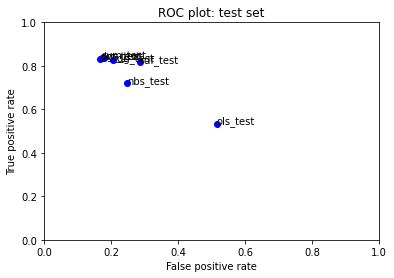

In [43]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

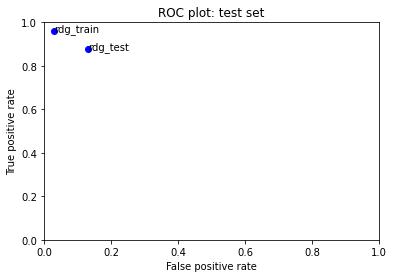

In [106]:
fits = [rdg_performance_train, rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()